# Import libraries

In [ ]:
pip install tensorflow optuna optuna-dashboard xgboost shap richdem

In [ ]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
import tensorflow
import io
import os
from PIL import Image
import seaborn as sns
import richdem as rd

import tensorflow as tf
import tensorflow.math
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical

import xgboost as xgb
from xgboost import XGBRegressor
from pysr import PySRRegressor
import random

import cartopy
import cartopy.crs as ccrs
from matplotlib.image import imread
import matplotlib.ticker as mticker

plt.rcParams['figure.figsize'] = (12,12)

# Load regional climate model (MAR) output over the Greenland Ice Sheet

#### Load local MAR output for 2020 on 6.5km

In [4]:
# if loading from LEAP/Pangeo
# url = 'gs://leap-persistent/raf-antwerpen/MARv3.12-6_5km-daily-ERA5-2020.zarr'
# ds2020 = xr.open_dataset(url, engine='zarr', chunks={})

# or if loading from local
ds2020 = xr.open_dataset('./MARv3.12-6_5km-daily-ERA5-2020.nc')

#### Set parameters

In [5]:
jun1 = 151
aug31 = 242
numberdays = aug31-jun1+1
jun1_leap = jun1 + 1
aug31_leap = aug31 + 1

numberyears = 22
numberdaystot = numberyears * numberdays
n_feature = 23
n_lat = 415
n_lon = 230

In [6]:
LAT = ds2020.LAT.values
LON = ds2020.LON.values
LAT_SW = LAT[:int(n_lat/2), :int(n_lon/2)]
LON_SW = LON[:int(n_lat/2), :int(n_lon/2)]
AL2_2020 = ds2020.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]

#### Calculate slope and aspect of ice sheet

In [ ]:
SH_vals = rd.rdarray(ds2020.SH.values, no_data=-9999)

slope = rd.TerrainAttribute(SH_vals/1000, attrib='slope_degrees')
aspect = rd.TerrainAttribute(SH_vals, attrib='aspect')

In [ ]:
x = np.zeros((numberyears, numberdays, n_lat, n_lon, n_feature))

for i in range(22):
    print(i)
    year = i + 2000
    url = f"gs://leap-persistent/raf-antwerpen/MARv3.12-6_5km-daily-ERA5-{year}.zarr"
    ds = xr.open_dataset(url, engine='zarr', chunks={})

    # or if loading from local
    # ds = xr.open_dataset('./MARv3.12-6_5km-daily-ERA5-{year}.nc')

    x[i,:,:,:,0] = ds.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]
    x[i,:,:,:,1] = ds.TT.values[jun1:aug31+1,0,:n_lat,:n_lon]
    x[i,:,:,:,2] = ds.RU.values[jun1:aug31+1,0,:n_lat,:n_lon]
    x[i,:,:,:,3] = ds.SWU.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,4] = ds.SWD.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,5] = ds.LWU.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,6] = ds.LWD.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,7] = ds.SHF.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,8] = ds.LHF.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,9] = ds.CD.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,10] = ds.CM.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,11] = ds.CU.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,12] = ds.COD.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,13] = np.mean(ds.RO1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
    x[i,:,:,:,14] = ds.UU.values[jun1:aug31+1,0,:n_lat,:n_lon]
    x[i,:,:,:,15] = ds.VV.values[jun1:aug31+1,0,:n_lat,:n_lon]
    x[i,:,:,:,16] = ds.SU.values[jun1:aug31+1,0,:n_lat,:n_lon]
    x[i,:,:,:,17] = np.mean(ds.WA1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
    x[i,:,:,:,18] = ds.SF.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,19] = ds.RF.values[jun1:aug31+1,:n_lat,:n_lon]
    
    # repeat the same data for each day for SH, SOL, slope, aspect, algnan since they do not vary temporally.
    for j in range(aug31-jun1+1):
        x[i,j,:,:,20] = ds2020.SH.values[:n_lat,:n_lon]
        x[i,j,:,:,21] = slope[:n_lat,:n_lon]
        x[i,j,:,:,22] = aspect[:n_lat,:n_lon]

In [297]:
np.shape(x)

(22, 92, 415, 230, 23)

In [298]:
# only use lower left quadrant of Greenland ice sheet
x = x[:,:,:int(n_lat/2),:int(n_lon/2),:]
x = x.reshape(numberdaystot, int(n_lat/2), int(n_lon/2), 23)

In [300]:
# Only include data below 70 N
x2 = np.zeros((2024,207,115,23))
for i in range(23):
    x2[:,:,:,i] = np.where(LAT_SW>70, np.nan, x[:,:,:,i])
x = x2

In [301]:
# np.save('x.npy', x)

In [7]:
# x = np.load('./x.npy')

# Load MODIS albedo data

In [7]:
path = './MOD10A1_albedo_MARproj_6_5km/'
dir_list = np.sort(os.listdir(path))
dir_list = dir_list[:]
dir_list

array(['20000601_albedo.tif', '20000602_albedo.tif',
       '20000603_albedo.tif', ..., '20210829_albedo.tif',
       '20210830_albedo.tif', '20210831_albedo.tif'], dtype='<U19')

#### Create nan arrays for days where I don't have MODIS data

In [8]:
modisnan = np.zeros((415,230))
modisnan = np.where(modisnan == 0, np.nan, np.nan)

#### Flip matrix right-side up and place in new matrix 'y'

In [9]:
y = np.zeros((numberdaystot,415,230,1))

for i in range(65):
    f = dir_list[i]
    im = Image.open(path + f)
    y[i,:,:,0] = np.flipud(np.array(im))

for i in range(65,78):
    y[i,:,:,0] = modisnan

for i in range(78,107):
    f = dir_list[i-13]
    im = Image.open(path + f)
    y[i,:,:,0] = np.flipud(np.array(im))

for i in range(107,124):
    y[i,:,:,0] = modisnan

for i in range(124,numberdaystot):
    f = dir_list[i-29]
    im = Image.open(path + f)
    y[i,:,:,0] = np.flipud(np.array(im))

#### Turn 255's into NaNs, divide by 100 to get albedo in 0-1 range

In [10]:
y = np.where(y == 255, np.nan, y)
y = y/100

#### Load bare ice mask (from Antwerpen et al., 2022). This variables gives 1's for bare ice and NaNs for non-bare ice (snow, land, or ocean) daily for June, July, and August in 2000-2021. Note: the bare ice mask show where bare ice is simultaneously observed with MODIS and modeled with MAR, on the same pixel.

In [11]:
ds_bie = sio.loadmat('./sboth_6km.mat')
bareice = np.flipud(ds_bie['sboth_6km'])
bareice = np.transpose(bareice, (2, 3, 0, 1))
bareice = bareice.reshape(numberdaystot, n_lat, n_lon)

#### Multiply with bare ice matrix to extract only bare ice albedo values

In [12]:
y = y[:,:,:,0] * bareice

#### Only use southern half or southwest quadrant

In [13]:
# only use lower left quadrant
y = y[:,:int(n_lat/2),:int(n_lon/2)]

In [ ]:
# np.save('y.npy', y)

In [8]:
# y = np.load('./y.npy')

In [9]:
# remove everyting above 70N
y2 = np.where(LAT_SW>70, np.nan, y)
y = y2

# Find 2-sigma ice albedo cut-off values for MODIS

In [10]:
y_mean = np.nanmean(y)
y_std = np.nanstd(y)
y_meanplus2sig = y_mean + 2 * y_std
y_meanminus2sig = y_mean - 2 * y_std

# Prepare data for training and testing

#### Create mask of valid albedo pixels and only use pixels (in x and y) that have a realistic albedo value (plusminus 2-sigma)

In [11]:
# only use MODIS albedo values within 2-sigma
y_masknan = np.where((y > y_meanminus2sig) & (y < y_meanplus2sig), 1, np.nan)

y_mask = y * y_masknan
x_mask = np.zeros((numberdaystot,x.shape[1],x.shape[2],x.shape[3]))
for i in range(x.shape[3]):
    x_mask[:,:,:,i] = x[:,:,:,i] * y_masknan[:,:,:]

In [12]:
# only use MAR data with less than 50% clouds simultaneously for CD, CM, and CU
cloud_mask = np.where((x_mask[:,:,:,9] < 0.5) & (x_mask[:,:,:,10] < 0.5) & (x_mask[:,:,:,11] < 0.5), 1, np.nan)

y_maskc = y_mask * cloud_mask

x_maskc = np.zeros((numberdaystot,x.shape[1],x.shape[2],x.shape[3]))
for i in range(x.shape[3]):
    x_maskc[:,:,:,i] = x_mask[:,:,:,i] * cloud_mask[:,:,:]

In [13]:
x_mask = x_maskc
y_mask = y_maskc

#### Standardize the data so all values are in the 0-range, plusminus a couple (2-5).

In [14]:
x_dum = np.zeros((x.shape[0], x.shape[1], x.shape[2], x.shape[3]))
vars_mean = np.zeros((x.shape[3],1))
vars_std = np.zeros((x.shape[3],1))

for i in range(x.shape[3]):
    
    vars_mean[i], vars_std[i] = np.nanmean(x_mask[:,:,:,i]), np.nanstd(x_mask[:,:,:,i])
    
    x_dum[:,:,:,i]   = (x_mask[:,:,:,i] - vars_mean[i])/vars_std[i]

x_mask = x_dum

In [15]:
# get all non-nan values in y (where bareice==1) and put them in a 1D array
y_nonan = y_mask[~np.isnan(y_mask)]

# create zero matrix of same lenth as y_nonan, with space for all 23 features in x
x_nonan = np.zeros((299125,x.shape[3]))

# put values of x (where bareice==1) in x_nonan, for all MAR features
for i in range(x.shape[3]):
    x_mask_dum = x_mask[:,:,:,i]
    x_nonan[:,i] = x_mask_dum[~np.isnan(x_mask_dum)]

In [16]:
# remove CD (9), CM (10), CU (11), and COD (12) from X_train
x_nonan_temp1 = np.zeros((299125, 19))

x_nonan_temp1[:,:9] = x_nonan[:,:9]
x_nonan_temp1[:,9:] = x_nonan[:,13:]

x_nonan = x_nonan_temp1

In [17]:
# remove SWU (3), LWU (5), SHF (7), and LHF (8)

x_nonan_temp2 = np.zeros((299125, 15))

x_nonan_temp2[:,:3] = x_nonan[:,:3]
x_nonan_temp2[:,3] = x_nonan[:,4]
x_nonan_temp2[:,4] = x_nonan[:,6]
x_nonan_temp2[:,5:] = x_nonan[:,9:]

x_nonan = x_nonan_temp2

# Train, test, validation split

In [18]:
X_train1, X_test, y_train1, y_test = train_test_split(x_nonan, y_nonan, test_size=(2/22), shuffle=False)

In [19]:
X_train1.shape, X_test.shape, y_train1.shape, y_test.shape

((271931, 15), (27194, 15), (271931,), (27194,))

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=(2/20), shuffle=False)

In [21]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((244737, 15), (27194, 15), (244737,), (27194,))

### Remove AL2 from X_test and move to X_test_AL2, so it is not used in the ML training phase. Do the same for X_train1, X_train, and X_val

In [22]:
X_test_AL2 = X_test[:,0]
X_test_temp = np.zeros((X_test.shape[0],14))
X_test_temp[:,:] = X_test[:,1:]
X_test = X_test_temp

X_train1_AL2 = X_train1[:,0]
X_train1_temp = np.zeros((X_train1.shape[0],14))
X_train1_temp[:,:] = X_train1[:,1:]
X_train1 = X_train1_temp

X_train_AL2 = X_train[:,0]
X_train_temp = np.zeros((X_train.shape[0],14))
X_train_temp[:,:] = X_train[:,1:]
X_train = X_train_temp

X_val_AL2 = X_val[:,0]
X_val_temp = np.zeros((X_val.shape[0],14))
X_val_temp[:,:] = X_val[:,1:]
X_val = X_val_temp

In [23]:
# create mean and std for AL2
AL2_mean = vars_mean[0]
AL2_std = vars_std[0]

In [24]:
# create mean and std for all MAR features
vars_mean_temp = np.zeros((vars_mean.shape[0]-1))
vars_mean_temp[:] = vars_mean[1:,0]
vars_mean = vars_mean_temp

vars_std_temp = np.zeros((vars_std.shape[0]-1))
vars_std_temp[:] = vars_std[1:,0]
vars_std = vars_std_temp

In [25]:
# remove CD, CM, CU, and COD from vars_mean and vars_std
vars_mean_dum = np.zeros((18,1))
vars_std_dum = np.zeros((18,1))

vars_mean_dum[:8,0] = vars_mean[:8]
vars_mean_dum[8:,0] = vars_mean[12:]
vars_std_dum[:8,0] = vars_std[:8]
vars_std_dum[8:,0] = vars_std[12:]

vars_mean = vars_mean_dum
vars_std = vars_std_dum

In [26]:
# remove SWU, LWU, SHF, and LHF from vars_mean and vars_std
vars_mean_dum2 = np.zeros((14,1))
vars_std_dum2 = np.zeros((14,1))

vars_mean_dum2[:2] = vars_mean[:2]
vars_mean_dum2[2] = vars_mean[3]
vars_mean_dum2[3] = vars_mean[5]
vars_mean_dum2[4:] = vars_mean[8:]

vars_std_dum2[:2] = vars_std[:2]
vars_std_dum2[2] = vars_std[3]
vars_std_dum2[3] = vars_std[5]
vars_std_dum2[4:] = vars_std[8:]

vars_mean = vars_mean_dum2
vars_std = vars_std_dum2

# Equation Discovery

In [27]:
dum = list(set(np.arange(0,y_train.shape[0])))
dum_rand = random.sample(dum, k=5000)

In [30]:
model = PySRRegressor(
    populations=40,
    population_size=40,
    ncyclesperiteration=40,
    model_selection="best",
    unary_operators=["neg", "sin", "cos", "square", "cube", "exp", "abs", "log", "log10", "log2", "sqrt", "tan", "sinh", "cosh", "tanh",
                     "atan", "asinh", "acosh", "atanh"],
    binary_operators=["+", "-", "/", "*", "^"],
    complexity_of_operators={"*": 3, "+": 3, "-": 3, "neg": 3, "square": 3,
                             "/": 6, "abs": 6, "sqrt": 6, "cube": 6,
                             "exp": 9, "log": 9, "log10": 9, "log2": 9, "sin": 9, "cos": 9, "tan": 9, "sinh": 9, "cosh": 9, "tanh": 9,
                             "^": 27, "atan": 27, "asinh": 27, "acosh":27, "atanh": 27},
    maxsize=30,
    niterations=30,
    select_k_features=7,
    timeout_in_seconds=1000
)

In [31]:
model.fit(X_train[dum_rand,:], y_train[dum_rand])

/Users/raf/mambaforge/envs/keras/lib/python3.9/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Using features ['x0' 'x1' 'x3' 'x6' 'x7' 'x11' 'x13']
Compiling Julia backend...


/Users/raf/mambaforge/envs/keras/lib/python3.9/site-packages/julia/juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `release` channel is 1.10.4+0.x64.apple.darwin14. You currently have `1.9.3+0.x64.apple.darwin14` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.4+0.x64.apple.darwin14 and update the `release` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))
/Users/raf/mambaforge/envs/keras/lib/python3.9/site-packages/julia/juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `release` channel is 1.10.4+0.x64.apple.darwin14. You currently have `1.9.3+0.x64.apple.darwin14` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.4+0.x64.apple.darwin14 and update the `release` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))
/Users/raf/mambaforge/envs/keras/lib/python3.9/site-packages/julia/juliainfo.py:93: UserWarnin

Started!

Expressions evaluated per second: 4.190e+04
Head worker occupation: 15.3%
Progress: 571 / 1200 total iterations (47.583%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.045e-02  1.594e+01  y = 0.41686
5           1.045e-02  2.980e-08  y = (0.71883 * 0.57994)
8           1.045e-02  3.974e-08  y = (square(0.5842) * 1.2214)
9           9.195e-03  1.278e-01  y = ((-0.033707 * x0) - -0.41925)
13          8.918e-03  7.665e-03  y = ((-0.02488 * (x0 - x6)) - -0.41876)
17          8.875e-03  1.186e-03  y = ((-0.019066 * ((x0 - x6) - x7)) - -0.41899)
21          8.801e-03  2.111e-03  y = ((((0.0045307 - (x0 - x6)) - x3) * 0.017993) - -0.41912)
25          8.801e-03  4.262e-06  y = (((((0.0045307 * x6) - (x0 - x6)) - x3) * 0.017993) - -0.4...
                                  1912)
-------------------------------------------------------------------------------------

PySRRegressor.equations_ = [
	   pick         score                                           equation  \
	0        0.000000e+00                                         0.41688195   
	1        4.101513e-08                    (square(0.5842031) * 1.2213523)   
	2  >>>>  1.278213e-01                ((-0.033707336 * x0) - -0.41924915)   
	3        7.665295e-03         ((-0.024881033 * (x0 - x6)) - -0.41875917)   
	4        3.297510e-03   ((((x6 - x0) - x3) * 0.017993087) - -0.41912368)   
	5        7.949396e-05  (((((x6 - x0) * 1.0368136) - x3) * 0.017993087...   
	6        9.893646e-05  (((((0.05160766 * square(x1)) - (x0 - x6)) - x...   
	
	       loss  complexity  
	0  0.010449           1  
	1  0.010449           8  
	2  0.009195           9  
	3  0.008918          13  
	4  0.008801          17  
	5  0.008798          21  
	6  0.008792          28  
]

In [32]:
print(model)

PySRRegressor.equations_ = [
	   pick         score                                           equation  \
	0        0.000000e+00                                         0.41688195   
	1        4.101513e-08                    (square(0.5842031) * 1.2213523)   
	2  >>>>  1.278213e-01                ((-0.033707336 * x0) - -0.41924915)   
	3        7.665295e-03         ((-0.024881033 * (x0 - x6)) - -0.41875917)   
	4        3.297510e-03   ((((x6 - x0) - x3) * 0.017993087) - -0.41912368)   
	5        7.949396e-05  (((((x6 - x0) * 1.0368136) - x3) * 0.017993087...   
	6        9.893646e-05  (((((0.05160766 * square(x1)) - (x0 - x6)) - x...   
	
	       loss  complexity  
	0  0.010449           1  
	1  0.010449           8  
	2  0.009195           9  
	3  0.008918          13  
	4  0.008801          17  
	5  0.008798          21  
	6  0.008792          28  
]


In [33]:
model.sympy()

0.41924915 - 0.033707336*x0

In [40]:
# example output of PySR
albedo_pysr = (((((X_test[:,12] * (X_test[:,12] - (X_test[:,11] - 0.6554099))) + X_test[:,13]) - ((x0 + np.sin((x11 + 3.0620923) * (X_test[:,13] + 1.9172776))) - ((X_test[:,2] - (X_test[:,1] - X_test[:,10])) * 0.69949067))) * 0.022178084) - -0.40424114)

In [41]:
# MODIS-PySR metrics
R2_pixel = ma.corrcoef(y_test, albedo_pysr)[1,0]**2
mse_pixel = mean_squared_error(y_test, albedo_pysr)
mape_pixel = mean_absolute_percentage_error(y_test, albedo_pysr)
ssim_pixel = ssim(y_test, albedo_pysr, data_range=albedo_pysr.max() - albedo_pysr.min())

R2_pixel, mse_pixel, mape_pixel, ssim_pixel

(0.05546219231617262,
 0.01254069839913772,
 0.2523198268907647,
 0.3079147805902174)

In [42]:
albedo_MAR = ((X_test_AL2) * AL2_std) + AL2_mean

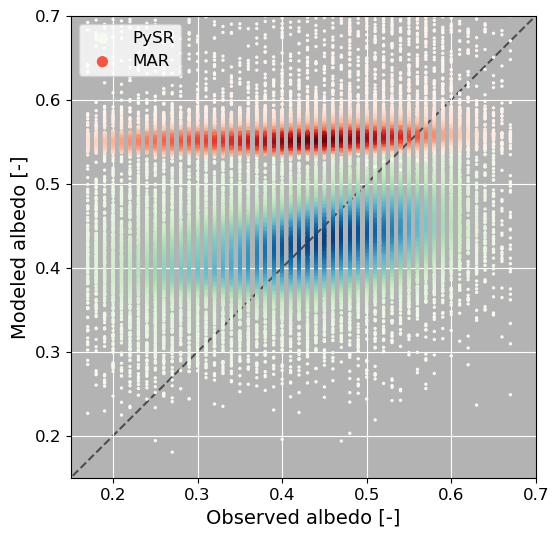

In [43]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()

# Calculate the point density
xy1 = np.vstack([y_test, albedo_pysr])
z1 = gaussian_kde(xy1)(xy1)
xy2 = np.vstack([y_test, albedo_MAR])
z2 = gaussian_kde(xy2)(xy2)

plt.plot(np.arange(-1,100,1), np.arange(-1,100,1), color=[0.3, 0.3, 0.3], linestyle='--', linewidth=1.5, zorder=1)
plt.scatter(y_test, albedo_pysr, c=z1, s=2, zorder=2, cmap='GnBu', label='PySR')
plt.scatter(y_test, albedo_MAR, c=z2, s=2, zorder=2, cmap='Reds', label='MAR')

# plt.text(0.665, 0.165, 'a)', fontsize=16)

plt.xlabel('Observed albedo [-]', fontsize=14)
plt.ylabel('Modeled albedo [-]', fontsize=14)
plt.grid(color='w', zorder=1)
ax.set_facecolor([0.7, 0.7, 0.7])
plt.tick_params(labelsize=12)
plt.xlim(0.15, 0.7);
plt.ylim(0.15, 0.7);

plt.legend(loc='upper left', fontsize=12, markerscale=5)